# Data-Analysis

Import and analyze data

In [15]:
import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%%time
prep_path = 'data/TreehouseCompendiumSamples_LibraryPrep.tsv'
prep_df = pd.read_csv(prep_path, sep='\t', index_col=0)

CPU times: user 40 ms, sys: 36 ms, total: 76 ms
Wall time: 74.8 ms


In [3]:
%%time
corr_path = 'data/v5_all_by_all.2018-02-04.tsv'
corr_df = pd.read_csv(corr_path, sep='\t', index_col=0)

CPU times: user 2min 10s, sys: 54.2 s, total: 3min 5s
Wall time: 3min 8s


In [4]:
%%time
meta_path = 'data/clinical.tsv'
meta_df = pd.read_csv(meta_path, sep='\t', index_col=0)

CPU times: user 156 ms, sys: 36 ms, total: 192 ms
Wall time: 160 ms


In [5]:
%%time
type_path = 'data/DiseaseAnnotations_2018-04_Labels.csv'
type_df = pd.read_csv(type_path, sep=',', index_col=1)

CPU times: user 48 ms, sys: 8 ms, total: 56 ms
Wall time: 53.9 ms


In [6]:
print(prep_df['libSelType'].value_counts())
print('NA', len(prep_df['libSelType']) - prep_df['libSelType'].count())

polyASelection            11505
riboDepletion               191
presumed riboDepletion       32
unknown                       9
exomeSelection                8
Name: libSelType, dtype: int64
NA 1003


In [7]:
print(len(prep_df), len(meta_df), len(corr_df))

12748 11340 11340


### [?] Duplicate Entries in library prep tsv

In [8]:
prep_df.loc['TCGA-AB-2860-03']

,UMENDcount,libSelType
THid,,
TCGA-AB-2860-03,NaN,polyASelection
TCGA-AB-2860-03,NaN,NaN


In [9]:
print(sum(prep_df.index.duplicated()))
print(sum(prep_df.index.duplicated(False)))
assert 1666 == 2 * 833

833
1666


There are 833 rows which are duplicated exactly once in the prep tsv.

### Method to get correlations from TSV or JSON

In [315]:
def get_correlations(sample):
    if sample in corr_df.index:
        corr_row = corr_df.loc[sample]
        corr_dict = {s: c for s, c in zip(corr_df.index, corr_row)}
    else:
        json_path = '/data/archive/downstream/%s/tertiary/treehouse-8.0.1_comp-v5/2.0.json' % sample
        if os.path.isfile(json_path):
            with open(json_path, 'r') as f:
                corr_dict = json.loads(f.read())['correlations_vs_focus_sample']
        else:
            return None
    return corr_dict

In [11]:
def get_samples(prefix):
    base_path = '/data/archive/downstream/'
    if prefix[:6] == 'TARGET':
        samples = [prefix+'-01A-01R']
    elif prefix[:2] == 'TH':
        prefix_path = '%s_S' % prefix
        samples = []
        for i in range(100):
            index = '%02d' % i
            sample_path = prefix_path+index
            if os.path.isdir(base_path+sample_path):
                samples.append(sample_path)
    else:
        raise Exception('Unknown prefix type')
    return samples

# Experiments/Results

In [12]:
sample_A = 'TH01_0121_S01'
sample_B = 'TH01_0123_S01'

# 1.

Recheck results: are most similar samples still AML in v5?

### TH01_0121_S01

https://jupyter.treehouse.gi.ucsc.edu/user/kellerjordan/files/TURG-Research/data/TH01_0121_S01/Summary.html

Of `6` most correlated samples, `3/6 = 0.5` were AML.

### TH01_0123_S01

https://jupyter.treehouse.gi.ucsc.edu/user/kellerjordan/files/TURG-Research/data/TH01_0123_S01/Summary.html

Of `6` most correlated samples, `6/6 = 1.0` were AML.

# 2.

For each, what fraction of top 95% (corr > 0.87) were AML?

In [314]:
def get_prefix(sample):
    last_pos = max(sample.rfind('_'), sample.rfind('-'))
    return sample[:last_pos]

def get_prefixes(samples):
    return [get_prefix(s) for s in samples]

def fraction_aml(sample, aml='acute myeloid leukemia', threshold=0.87):
    correlations = get_correlations(sample)
    if correlations is None:
        return -1
    
    top_samples = []
    for s, c in correlations.items():
        if c > threshold:
            top_samples.append(s)
    prefix_corr_samples = get_prefixes(top_samples)
    corr_diseases = type_df.loc[prefix_corr_samples]['Diagnosis/Disease']
    disease_counts = corr_diseases.value_counts()
    
    if aml in disease_counts:
        return disease_counts['acute myeloid leukemia'] / len(corr_diseases)
    else:
        return 0

In [309]:
print('%s:' % sample_A)
print(top_diseases(sample_A).value_counts())
print('Fraction AML:', fraction_aml(sample_A))
print()
print('%s:' % sample_B)
print(top_diseases(sample_B).value_counts())
print('Fraction AML:', fraction_aml(sample_B))

TH01_0121_S01:
acute myeloid leukemia              29
acute lymphoblastic leukemia         4
acute leukemia                       4
juvenile myelomonocytic leukemia     2
Name: Diagnosis/Disease, dtype: int64
Fraction AML: 0.74358974359

TH01_0123_S01:
acute myeloid leukemia          62
acute lymphoblastic leukemia    40
acute leukemia                   3
Name: Diagnosis/Disease, dtype: int64
Fraction AML: 0.590476190476


# 3.

Are the top most correlated samples still places in the AML cluster on tumormap?

https://tumormap.ucsc.edu/?p=CKCC/v5&node=TH26_0657_S04,TH26_0657_S05,TH26_0657_S03,TCGA-AB-2915-03,TCGA-AB-2868-03,TCGA-AB-2952-03&x=24,25,24,346,346,344&y=323,321,322,40,42,40


https://tumormap.ucsc.edu/?p=CKCC/v5&node=TCGA-AB-2934-03,TCGA-AB-2890-03,TCGA-AB-2927-03,TCGA-AB-2936-03,TCGA-AB-2915-03,TCGA-AB-2868-03&x=340,349,350,349,346,346&y=44,43,44,48,40,42

For the top six most correlated samples in each case, all that were labeled AML are placed in the AML cluster. Those that are labeled ALL are not.

# 4.

How correlated are other ALL samples with AML? Specifically, what impact does RiboD preparation have on their correlation? Use the `type_df` to find ALL samples of interest.

This section is the only one where preparation type matters, as in every other case I search only in the correlation matrix which contains only PolyA-prepared samples.

In [338]:
ALL_rows_type_df = type_df.loc[type_df['Diagnosis/Disease'] == 'acute lymphoblastic leukemia']
ALL_prefixes = list(ALL_rows_type_df.index)
ALL_samples_type_df = []
for prefix in ALL_rows.index:
    ALL_samples_type_df.extend(get_samples(prefix))
ALL_samples_meta_df = list(meta_df.loc[meta_df['disease'] == 'acute lymphoblastic leukemia'].index)
ALL_samples = ALL_samples_type_df + ALL_samples_meta_df
len(ALL_samples)

705

In [339]:
sources = ['THR', 'TH0', 'TARGET']

## TARGET data does not exist in file structure

In [343]:
%%time
fracs_aml = {}
missing_samples = []
for sample in ALL_samples:
    frac = fraction_aml(sample)
    if frac == -1:
        missing_samples.append(sample)
    else:
        fracs_aml[sample] = frac
fracs_aml_by_src = {}
for src in sources:
    fracs_aml_by_src[src] = [v for k, v in fracs_aml.items() if k[:len(src)] == src]

CPU times: user 6.51 s, sys: 160 ms, total: 6.67 s
Wall time: 6.6 s


## Issue: no files for TARGET

Number of ALL samples with prefix THR: 66


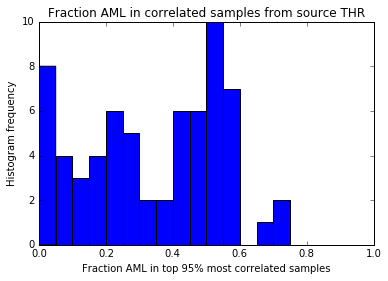

Number of ALL samples with prefix TH0: 20


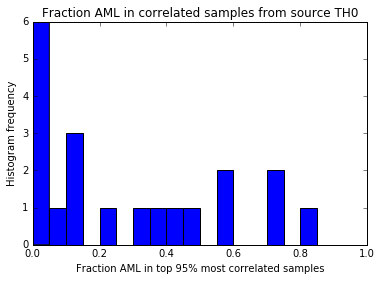

Number of ALL samples with prefix TARGET: 194


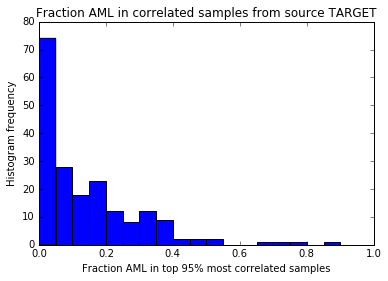

In [345]:
for src in sources:
    print('Number of ALL samples with prefix %s:' % src, len(fracs_aml_by_src[src]))
    plt.hist(fracs_aml_by_src[src], bins=20, range=(0, 1))
    plt.title('Fraction AML in correlated samples from source %s' % src)
    plt.xlabel('Fraction AML in top 95% most correlated samples')
    plt.ylabel('Histogram frequency')
    plt.show()

## Is there a correlation between data source and prep type?

In [346]:
samples_by_src = {}
for src in sources:
    samples_by_src[src] = [k for k in fracs_aml.keys() if k[:len(src)] == src]

## Overall prep type ratios from different sources

In [347]:
def get_prep_types(src):
    prep_types = []
    for s in prep_df.index:
        if src in s:
            t = prep_df.loc[s]['libSelType']
            if type(t) == pd.Series:
                t = t.iloc[0]
            prep_types.append(t)
    prep_types = pd.Series(prep_types)
    return prep_types

In [348]:
print('Source: TARGET')
print(get_prep_types('TARGET').value_counts())
print('\nSource: TH0')
print(get_prep_types('TH0').value_counts())
print('\nSource: THR')
print(get_prep_types('THR').value_counts())

Source: TARGET
polyASelection    1053
riboDepletion       13
dtype: int64

Source: TH0
polyASelection            194
riboDepletion              60
presumed riboDepletion     32
unknown                     9
dtype: int64

Source: THR
polyASelection    650
riboDepletion     118
exomeSelection      8
dtype: int64


## Prep types for samples highly correlated to ALL (TARGET samples not in prep df)

In [349]:
def get_prep_types_samples(src):
    samples = prep_df.loc[samples_by_src[src]]
    return samples['libSelType']

In [350]:
print('Source: TH0')
print(get_prep_types_samples('TH0').value_counts())

print('\nSource: THR')
print(get_prep_types_samples('THR').value_counts())

Source: TH0
riboDepletion             13
polyASelection             5
presumed riboDepletion     2
Name: libSelType, dtype: int64

Source: THR
polyASelection    66
Name: libSelType, dtype: int64


In [351]:
def plot_frac_aml_by_prep(src):
    samples = samples_by_src[src]
    prep_types = prep_df.loc[samples]['libSelType']
    corr_by_prep = {}
    for s, t in zip(samples, prep_types):
        if t not in corr_by_prep:
            corr_by_prep[t] = []
        corr_by_prep[t].append(fracs_aml[s])
    for t, corrs in corr_by_prep.items():
        print('Number of ALL samples prep`d with %s: %d' % (t, len(corrs)))
        plt.hist(corrs, bins=20, range=(0, 1.0))
        plt.title('Fraction AML in correlated samples prep`d by %s' % t)
        plt.xlabel('Fraction AML in top 95% correlated samples')
        plt.ylabel('Histogram frequency')
        plt.show()

Source: TH0
Number of ALL samples prep`d with riboDepletion: 13


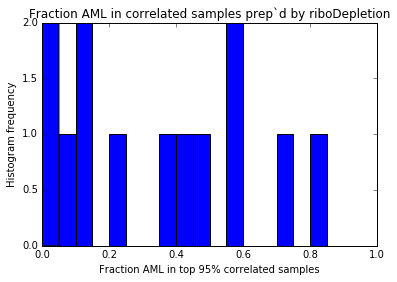

Number of ALL samples prep`d with polyASelection: 5


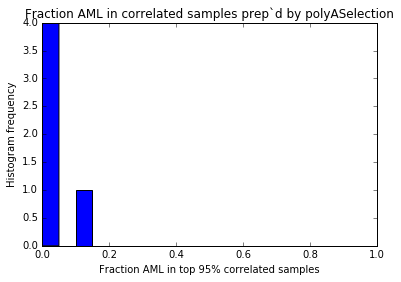

Number of ALL samples prep`d with presumed riboDepletion: 2


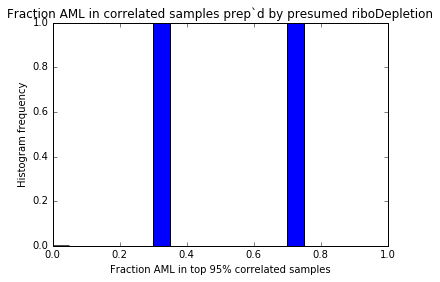

Source: THR
Number of ALL samples prep`d with polyASelection: 66


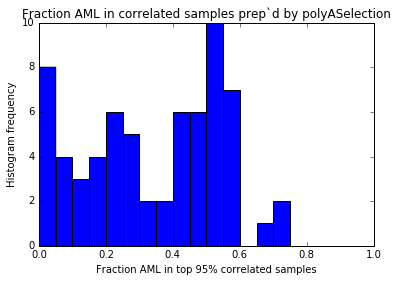

Source: TARGET
Number of ALL samples prep`d with nan: 14


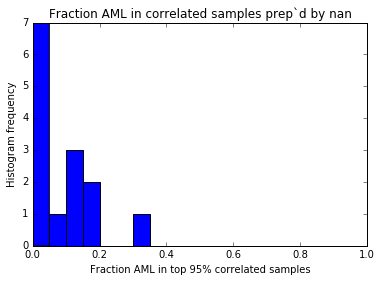

Number of ALL samples prep`d with polyASelection: 180


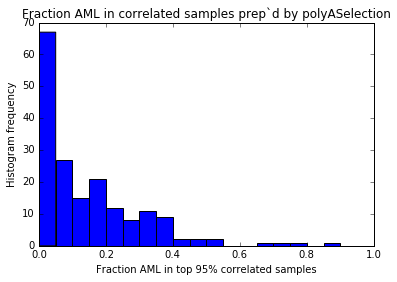

In [354]:
print('Source: TH0')
plot_frac_aml_by_prep('TH0')
print('Source: THR')
plot_frac_aml_by_prep('THR')
print('Source: TARGET')
plot_frac_aml_by_prep('TARGET')

# 5.

Find the samples of any type that are most correlated with AML (but not AML themselves).

In [355]:
def get_prefix(sample):
    if 'TARGET' in sample:
        return sample[:16]
    elif 'TCGA' in sample:
        return sample[:12]
    elif 'THR' in sample:
        return sample[:10]
    elif 'TH' in sample:
        return sample[:9]
    else:
        raise Exception('Unknown data source')

In [356]:
%%time
threshold = 0.3
amlish_samples = []
for sample in corr_df.index:
    try:
        is_aml = type_df.loc[get_prefix(sample)]['Diagnosis/Disease'] == 'acute myeloid leukemia'
        if not is_aml:
            f = fraction_aml(sample)
            if f > threshold:
                amlish_samples.append(sample)
    except Exception as e:
        print('error:', sample)
        print(e)
print(len(amlish_samples))

81
CPU times: user 3min 22s, sys: 0 ns, total: 3min 22s
Wall time: 3min 22s


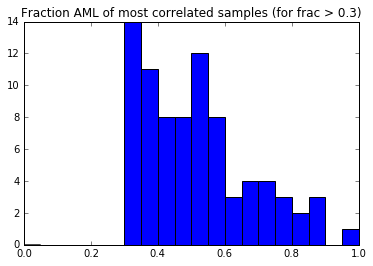

In [357]:
correlations = []
for s in amlish_samples:
    correlations.append(fraction_aml(s))
plt.hist(correlations, bins=20, range=(0, 1))
plt.title('Fraction AML of most correlated samples (for frac > 0.3)')
plt.show()

In [358]:
diseases = []
for s in amlish_samples:
    d = type_df.loc[get_prefix(s)]['Diagnosis/Disease']
    diseases.append(d)
pd.Series(diseases).value_counts()

acute lymphoblastic leukemia           67
acute leukemia                          6
acute leukemia of ambiguous lineage     2
juvenile myelomonocytic leukemia        2
lymphoma                                1
mixed phenotype acute leukemia          1
leukemia                                1
acute undifferentiated leukemia         1
dtype: int64

In [359]:
sample_1 = ALL_samples[-27]
sample_2 = amlish_samples[-1]

print(sample_1, '\t', fraction_aml(sample_1))
print(sample_2, '\t\t', fraction_aml(sample_2))

TARGET-10-PARPZJ-03 	 0
TARGET-10-PARMXF-04 		 0.864285714286


# Results So Far

#### (subject to data bias due to missing TARGET and some TH0 files)

Preparation type and dataset source seem to have little impact on correlation to AML. Many leukemia are often correlated to AML.

The distribution of correlations seems different using PolyA / RiboD prep